In [1]:
#-------------------基础工具------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import time
import os
#------------------sklearn-------------------------------
from sklearn.cluster import k_means
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.manifold import t_sne
import  sklearn.learning_curve 
from sklearn.tree import DecisionTreeClassifier

#------------------keras --------------------------------
from keras.utils import plot_model
from keras.layers import Dropout
import keras 
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv1D
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPool2D

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras import Sequential


#-----------------xgboost----------------------------

import xgboost as xgb

#---------------------参数设置----------------------------
%matplotlib inline
#CPU还是GPU
import copy


namespace='原始抽样特征_局部概率_全部数据'

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


In [2]:
def calc_kappa(y_true,y_pre):
    p0=0
    pe=0
    confux_m=confusion_matrix(y_true,y_pre)
    confux_m_sum=confux_m.sum()
    for i in range(len(confux_m)):
        p0+=confux_m[i][i]
        pe+=((confux_m[:,i]).sum())*((confux_m[i,:]).sum())
    p0=p0/confux_m_sum
    pe=pe/(confux_m_sum*confux_m_sum)
    kappa=(p0-pe)/(1-pe)
    return kappa

数据的导入，切分，标准化

In [4]:
Salinas_all_data=pd.read_table('../中鸿儒的数据/Salinas_FCwithRC.txt')
Salinas_df4_raw=pd.read_csv('Salinas_bandselect/SalinasResize_FCwithRC_No_4.txt',delimiter='\t',index_col=False)
Salinas_df5_raw=pd.read_csv('Salinas_bandselect/SalinasResize_FCwithRC_No_5.txt',delimiter='\t',index_col=False)
all_columns=Salinas_all_data.columns.tolist()
df4_columns=Salinas_df4_raw.columns[:-3].tolist()
df5_columns=Salinas_df5_raw.columns[:-3].tolist()
df4_all_columns=[v[1:] for v in df4_columns if v[1:]  in all_columns]
df5_all_columns=[v[1:] for v in df5_columns if v[1:]  in all_columns]
df4_all_columns.extend(['row','col','Type'])
df5_all_columns.extend(['row','col','Type'])
Salinas_df4_raw=Salinas_all_data[df4_all_columns]
Salinas_df5_raw=Salinas_all_data[df5_all_columns]
row_index=Salinas_df4_raw.row.max()
col_index=Salinas_df4_raw.col.max()
df4_new_columns=Salinas_df4_raw.columns[:-3]
df5_new_columns=Salinas_df5_raw.columns[:-3]


In [5]:
conv_shape=(row_index+3,col_index+3)
img_shape=(row_index+1,col_index+1)
_=(row_index+2,col_index+2)

label_img=np.ndarray(shape=(conv_shape[0],conv_shape[1]),dtype=np.int32)
label_img[:,:]=-1
type_m=Salinas_df4_raw.Type.reshape(img_shape[0],img_shape[1])
label_img[1:row_index+2,1:col_index+2]=type_m

for k in range(1,17):
    
    type_prob_m=(label_img==k).astype('int32')/9

    #处理训练集
    for col in df4_new_columns:
        print(k,col)
        con_var_img=np.zeros((conv_shape[0],conv_shape[1]))
        con_var_img[1:row_index+2,1:col_index+2]=Salinas_df4_raw[col].reshape(img_shape[0],img_shape[1])
        con_re=np.zeros((img_shape[0],img_shape[1]))
        for i in range(1,row_index+2):
            for j in range(1,col_index+2):
                con_re[i-1][j-1]=(con_var_img[i-1:i+2,j-1:j+2]*type_prob_m[i-1:i+2,j-1:j+2]).sum()
        
        Salinas_df4_raw[col+'_'+str(k)+'_prob']=con_re.flatten()
    
    #处理测试集
    for col in df5_new_columns:
        print(k,col)
        con_var_img=np.zeros((conv_shape[0],conv_shape[1]))
        con_var_img[1:row_index+2,1:col_index+2]=Salinas_df5_raw[col].reshape(img_shape[0],img_shape[1])
        con_re=np.zeros((img_shape[0],img_shape[1]))
        for i in range(1,row_index+2):
            for j in range(1,col_index+2):
                con_re[i-1][j-1]=(con_var_img[i-1:i+2,j-1:j+2]*type_prob_m[i-1:i+2,j-1:j+2]).sum()
        
        Salinas_df5_raw[col+'_'+str(k)+'_prob']=con_re.flatten()

1 2
1 10
1 18
1 26
1 34
1 42
1 50
1 58
1 66
1 74
1 82
1 90
1 98
1 106
1 114
1 122
1 130
1 138
1 146
1 170
1 178
1

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 3
1 11
1 19
1 27
1 35
1 43
1 51
1 59
1 67
1 75
1 83
1 91
1 99
1 107
1 115
1 123
1 131
1 139
1 147
1 171
1 179
2 2
2 10
2 18
2 26
2 34
2 42
2 50
2 58
2 66
2 74
2 82
2 90
2 98
2 106
2 114
2 122
2 130
2 138
2 146
2 170
2 178
2 3
2 11
2 19
2 27
2 35
2 43
2 51
2 59
2 67
2 75
2 83
2 91
2 99
2 107
2 115
2 123
2 131
2 139
2 147
2 171
2 179
3 2
3 10
3 18
3 26
3 34
3 42
3 50
3 58
3 66
3 74
3 82
3 90
3 98
3 106
3 114
3 122
3 130
3 138
3 146
3 170
3 178
3 3
3 11
3 19
3 27
3 35
3 43
3 51
3 59
3 67
3 75
3 83
3 91
3 99
3 107
3 115
3 123
3 131
3 139
3 147
3 171
3 179
4 2
4 10
4 18
4 26
4 34
4 42
4 50
4 58
4 66
4 74
4 82
4 90
4 98
4 106
4 114
4 122
4 130
4 138
4 146
4 170
4 178
4 3
4 11
4 19
4 27
4 35
4 43
4 51
4 59
4 67
4 75
4 83
4 91
4 99
4 107
4 115
4 123
4 131
4 139
4 147
4 171
4 179
5 2
5 10
5 18
5 26
5 34
5 42
5 50
5 58
5 66
5 74
5 82
5 90
5 98
5 106
5 114
5 122
5 130
5 138
5 146
5 170
5 178
5 3
5 11
5 19
5 27
5 35
5 43
5 51
5 59
5 67
5 75
5 83
5 91
5 99
5 107
5 115
5 123
5 131
5 139
5 147
5 171

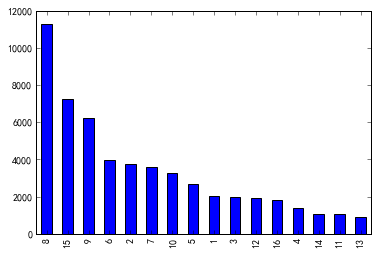

In [23]:
# os.mkdir(namespace)
# os.chdir(namespace)
Salinas_df4_raw.to_csv('SalinasResize_FCwithRC_No_4'+namespace+'.csv')
Salinas_df5_raw.to_csv('SalinasResize_FCwithRC_No_5'+namespace+'.csv')

Salinas_df4_raw=Salinas_df4_raw[Salinas_df4_raw.Type!=0]
Salinas_df5_raw=Salinas_df5_raw[Salinas_df5_raw.Type!=0]
Salinas_df4=copy.deepcopy(Salinas_df4_raw)
Salinas_df5=copy.deepcopy(Salinas_df5_raw)
std=StandardScaler()
Salinas_df4.pop('row')
Salinas_df4.pop('col')
y_train=Salinas_df4.pop('Type')
x_train=Salinas_df4
x_train=std.fit_transform(x_train)
Salinas_df5.pop('row')
Salinas_df5.pop('col')
y_test=Salinas_df5.pop('Type')
x_test=Salinas_df5
x_test=std.fit_transform(x_test)
y_true=y_test
y_train.value_counts().plot(kind='bar')

In [9]:

piplines=[LogisticRegression(),GradientBoostingClassifier(),RandomForestClassifier(),DecisionTreeClassifier(),KNeighborsClassifier(),SVC()]
pipline_fit_score={'accuracy':[]}
pipline_test_score={'accuracy':[]}
pipline_fit_test_score={'fit-accuracy':[],'test-accuracy':[]}
kappas_={'kappa':[]}

clf_names=['逻辑回归','梯度提升决策树','随机森林','决策树','K-临近','SVM']
for clf_name,clf in zip(clf_names,piplines):
    
    os.mkdir(clf_name)
    
    clf.fit(x_train,y_train)
    
    print('拟合',clf_name,clf.score(x_train,y_train))
    print('测试',clf_name,clf.score(x_test,y_test))
    
    y_pre=clf.predict(x_test)
    
    pipline_fit_score['accuracy'].append(clf.score(x_train,y_train))
    
    pipline_test_score['accuracy'].append(clf.score(x_test,y_test))
    
    kappas_['kappa'].append(calc_kappa(y_true,y_pre))
    
    pipline_fit_test_score['fit-accuracy'].append(clf.score(x_train,y_train))
    
    pipline_fit_test_score['test-accuracy'].append(clf.score(x_test,y_test))
    
    #混淆矩阵
    pd.DataFrame(confusion_matrix(y_true,y_pre),index=range(1,17),columns=range(1,17)).to_csv(clf_name+'/'+clf_name+'_confux_matrix.csv')  
    
    #错的点的坐标
    Salinas_df5_raw[y_true!=y_pre][['row','col']].to_csv(clf_name+'/false_loc.csv',index=None,columns=None)
    
    Salinas_df5_raw['pre_type']=y_pre
    #预测值的输出
    Salinas_df5_raw[['row','col','pre_type']].to_csv(clf_name +'/_pre.csv')
    
os.mkdir('统计量')

print('正在输出分类器准确率')

#准确率
pd.DataFrame(pipline_fit_score,index=clf_names).sort_values(by='accuracy').to_csv('统计量/fit_accuracy.csv')
pd.DataFrame(pipline_test_score,index=clf_names).sort_values(by='accuracy').to_csv('统计量/test_accuracy.csv')
pd.DataFrame(pipline_fit_test_score,index=clf_names).to_csv('统计量/fit_test_accuracy.csv')
#kappa系数
print('正在输出kappa系数')
pd.DataFrame(kappas_,index=clf_names).sort_values(by='kappa').to_csv('统计量/kappa.csv')

拟合 逻辑回归 0.9148257968865826
测试 逻辑回归 0.9099332839140104
拟合 梯度提升决策树 0.9799851742031134
测试 梯度提升决策树 0.9459599703484062
拟合 随机森林 0.9979985174203113
测试 随机森林 0.9613046701260193
拟合 决策树 1.0
测试 决策树 0.9165307635285397
拟合 K-临近 0.9487768717568569
测试 K-临近 0.9455151964418087
拟合 SVM 0.9213491475166791
测试 SVM 0.9195700518902891
正在输出分类器准确率
正在输出kappa系数


In [10]:
xgb_data_train=xgb.DMatrix(x_train,label=y_train)
xgb_data_test=xgb.DMatrix(x_test,label=y_test)
params={'max_depth':10,'eta':0.1,'silent':0,'objective':'multi:softmax','num_class':17,'alpha':0.5}
eval_reslut={}
bst=xgb.train(params, 
          xgb_data_train, 
          num_boost_round=400, 
          evals=[(xgb_data_train,'train'),(xgb_data_test,'test')], 
          obj=None, 
          feval=None, 
          maximize=False, 
          early_stopping_rounds=None,
          evals_result=eval_reslut,
          verbose_eval=100,
          xgb_model=None,
          callbacks=None)
xgb_data_test=xgb.DMatrix(x_test)
y_pre=bst.predict(xgb_data_test)
y_true=y_test

y_pre=bst.predict(xgb_data_test)
y_fit_pre=bst.predict(xgb_data_train)
y_true=y_test
accuracy_score(y_true,y_pre)

[0]	train-merror:0	test-merror:0
[100]	train-merror:0	test-merror:0
[200]	train-merror:0	test-merror:0
[300]	train-merror:0	test-merror:0
[399]	train-merror:0	test-merror:0


1.0

In [15]:
clf_names=[]
pipline_fit_score={'accuracy':[]}
pipline_test_score={'accuracy':[]}
pipline_fit_test_score={'fit-accuracy':[],'test-accuracy':[]}
kappas_={'kappa':[]}

os.mkdir('XGBoost')
clf_name='XGBoost'
clf_names.append(clf_name)

pipline_fit_score['accuracy'].append(accuracy_score(y_true,y_fit_pre))

pipline_test_score['accuracy'].append(accuracy_score(y_true,y_fit_pre))

kappas_['kappa'].append(calc_kappa(y_true,y_pre))

pipline_fit_test_score['fit-accuracy'].append(accuracy_score(y_true,y_fit_pre))

pipline_fit_test_score['test-accuracy'].append(accuracy_score(y_true,y_pre))

pd.DataFrame(confusion_matrix(y_true,y_pre),index=range(1,17),columns=range(1,17)).to_csv(clf_name+'/'+clf_name+'_confux_matrix.csv')  

Salinas_df5_raw[y_true!=y_pre][['row','col']].to_csv(clf_name+'/false_loc.csv',index=None,columns=None)

Salinas_df5_raw['pre_type']=y_pre

Salinas_df5_raw[['row','col','pre_type']].to_csv( clf_name+'/_pre.csv')
                                      
os.mkdir('统计量')

print('正在输出分类器准确率')

pd.DataFrame(pipline_fit_score,index=clf_names).sort_values(by='accuracy').to_csv('统计量/fit_accuracy.csv')
pd.DataFrame(pipline_test_score,index=clf_names).sort_values(by='accuracy').to_csv('统计量/test_accuracy.csv')
pd.DataFrame(pipline_fit_test_score,index=clf_names).to_csv('统计量/fit_test_accuracy.csv')

print('正在输出kappa系数')
                                      
pd.DataFrame(kappas_,index=clf_names).sort_values(by='kappa').to_csv('统计量/kappa.csv')

正在输出分类器准确率
正在输出kappa系数


In [16]:
pd.DataFrame(eval_reslut['test']['merror'],columns=[namespace+'_loss']).to_csv('loss_.csv',index=None)

In [24]:
i=6
input_dim=x_train.shape[1]
output_dim=len(set(y_train.tolist()))
batch_size=32
lr=0.1
epochs=50
hidden_num = input_dim*i
hidden_num_2 = output_dim*i
ohe = OneHotEncoder()
y_train=ohe.fit_transform(np.matrix(y_train.values).T).toarray()
model=Sequential()
model.add(Dense(input_dim=input_dim,units=hidden_num))
model.add(Activation('relu'))
model.add(Dense(input_dim=hidden_num_2,units=output_dim))
optimizer=SGD(lr=lr)
model.compile(loss='mean_squared_error',optimizer=optimizer)
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1)

y_pre=model.predict_classes(x_test, batch_size=batch_size)
y_true=y_test
y_pre=y_pre+1


Epoch 1/50


InternalError: GPU sync failed

In [25]:
os.mkdir('NN')
clf_name='NN'
clf_names.append(clf_name)

pipline_fit_score['accuracy'].append(accuracy_score(y_true,y_fit_pre))

pipline_test_score['accuracy'].append(accuracy_score(y_true,y_fit_pre))

kappas_['kappa'].append(calc_kappa(y_true,y_pre))

pipline_fit_test_score['fit-accuracy'].append(accuracy_score(y_true,y_fit_pre))

pipline_fit_test_score['test-accuracy'].append(accuracy_score(y_true,y_pre))

pd.DataFrame(confusion_matrix(y_true,y_pre),index=range(1,17),columns=range(1,17)).to_csv(clf_name+'/'+clf_name+'_confux_matrix.csv')  

Salinas_df5_raw[y_true!=y_pre][['row','col']].to_csv(clf_name+'/false_loc.csv',index=None,columns=None)

Salinas_df5_raw['pre_type']=y_pre

Salinas_df5_raw[['row','col','pre_type']].to_csv( clf_name+'/_pre.csv')
                                      

print('正在输出分类器准确率')

pd.DataFrame(pipline_fit_score,index=clf_names).sort_values(by='accuracy').to_csv('统计量/fit_accuracy.csv')
pd.DataFrame(pipline_test_score,index=clf_names).sort_values(by='accuracy').to_csv('统计量/test_accuracy.csv')
pd.DataFrame(pipline_fit_test_score,index=clf_names).to_csv('统计量/fit_test_accuracy.csv')

print('正在输出kappa系数')
                                      
pd.DataFrame(kappas_,index=clf_names).sort_values(by='kappa').to_csv('统计量/kappa.csv')

正在输出分类器准确率
正在输出kappa系数


# 输出部分

交叉矩阵(准确率、召回率,F1)

kappa系数
准确率
kappa计算结果为-1~1，但通常kappa是落在 0~1 间，可分为五组来表示不同级别的一致性：
0.0~0.20极低的一致性(slight)、
0.21~0.40一般的一致性(fair)、
0.41~0.60 中等的一致性(moderate)、
0.61~0.80 高度的一致性(substantial)
0.81~1几乎完全一致(almost perfect)。


In [ ]:
clf_names=['逻辑回归','梯度提升决策树','随机森林','决策树','K-临近','SVM','XGBoost','NN']

losss下降过程(运算时间)

神经网络层数图片

学习曲线